In [1]:
from PIL import Image, ImageOps
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
import torch.backends.cudnn as cudnn
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as colormaps
import pandas as pd
from enum import Enum
import os
from typing import List, Tuple
import rasterio
import rasterio.plot
import math
import time
import gc
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import seaborn as sns

cudnn.benchmark = True
sns.set_theme()

In [2]:
is_dataset_sampled = False

In [3]:
ml_weights_dir = os.path.join('ML', 'weights')

In [4]:
gc.collect()
torch.cuda.empty_cache()

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [6]:
class_names =   ['CLR', 'FEW', 'SCT', 'BKN', 'OVC']
classes = list(range(len(class_names)))
class_dict = {name: i for i, name in enumerate(class_names)}

In [7]:
weights = EfficientNet_V2_S_Weights.DEFAULT

In [8]:
seq_model = efficientnet_v2_s(weights=weights)
print(seq_model)

freez_model_base = False
if freez_model_base:
    for param in seq_model.parameters(): #freeze model
        param.requires_grad = False

seq_model.classifier[1] = nn.Linear(1280, len(classes))
print(seq_model.classifier)
model = nn.DataParallel(seq_model)
model = model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [9]:
batch_size = 16

In [10]:
show_summary = False

if show_summary:
    summary(
        model,
        input_size=(batch_size, 3, 300, 300),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
    )

In [11]:
data_dir = 'data'
dataset_dir = os.path.join(data_dir, 'dataset')
if is_dataset_sampled:
    dataset_dir += '_sampled'

In [12]:
training_weights = pd.read_csv(os.path.join(dataset_dir, 'training_weights.csv'), index_col='label')
training_weights

,weight
label,
CLR,2.075961
FEW,13.056380
SCT,12.772134
BKN,8.036530
OVC,4.184498


In [13]:
class DatasetType(str, Enum):
    TRAINING = 'training'
    VALIDATION = 'validation'
    TEST = 'test'

class AimlsseImageDataset(Dataset):
    def __init__(self, type:DatasetType, dataset_dir:str, bands:List[str], station_radius:float,
                 transfrom=None, target_transform=None) -> None:
        super().__init__()
        self.bands_metadata = pd.read_csv(os.path.join(dataset_dir, f'bands_metadata.csv'))
        self.bands_metadata.set_index('band', inplace=True)
        bands_series = pd.Series(bands)
        invalid_bands = bands_series[~bands_series.isin(self.bands_metadata.index)].to_list()
        if any(invalid_bands):
            raise ValueError(f'Bands {invalid_bands} are not valid')
        if len(self.bands_metadata.loc[bands]['resolution [m]'].unique()) != 1:
            raise ValueError(f'Bands {bands} do not have the same resolution')
        self.bands = bands
        self.station_radius = station_radius
        self.img_labels = pd.read_csv(os.path.join(dataset_dir, f'{type.value}_labels.csv'))
        self.img_dir = os.path.join(dataset_dir, type.value)
        self.transform = transfrom
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, index) -> Tuple[np.ndarray, int, int]:
        image = self.get_image(index)
        label = self.get_label(index)
        return image, label, index
    
    def get_image(self, index) -> np.ndarray:
        path = self.get_image_path(index)
        image = rasterio.open(path)
        image_tensor = torch.from_numpy(image.read())
        image.close()
        # Select label and perform transformations
        if self.transform:
            image_tensor = self.transform(image_tensor)
        return image_tensor

    def get_label(self, index) -> int:
        label = class_dict[self.img_labels.iloc[index]['max cloud cover']]
        if self.target_transform:
            label = self.target_transform(label)
        return label
    
    def get_timedelta_minutes(self, index) -> float:
        return self.img_labels.iloc[index]['timedelta [minutes]']
    
    def get_image_path(self, index) -> str:
        return os.path.join(self.img_dir, self.img_labels.iloc[index]['station'],
                                  f'{self.img_labels.iloc[index].product_id}.tif')


In [14]:
composed_transforms = transforms.RandomOrder([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(90)
])

In [15]:
bands = ['B4', 'B3', 'B2']
station_radius = 8000.0
train_dataset = AimlsseImageDataset(DatasetType.TRAINING,           dataset_dir, bands, station_radius, transfrom=composed_transforms)
validation_dataset = AimlsseImageDataset(DatasetType.VALIDATION,    dataset_dir, bands, station_radius, transfrom=composed_transforms)
test_dataset = AimlsseImageDataset(DatasetType.TEST,                dataset_dir, bands, station_radius, transfrom=composed_transforms)

In [16]:
use_weighted_sampler = False
if use_weighted_sampler:
    num_samples = len(train_dataset)
    weights = [0] * num_samples
    for i in range(num_samples):
        label = train_dataset.get_label(i)
        weights[i] = training_weights.loc[class_names]['weight'].iloc[label]
    training_sampler = WeightedRandomSampler(weights, num_samples)

In [17]:
if use_weighted_sampler:
    train_dataloader =  DataLoader(train_dataset,       batch_size=batch_size, sampler=training_sampler)
else:
    train_dataloader =  DataLoader(train_dataset,       batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset,  batch_size=batch_size, shuffle=True)

In [18]:
show_samples = False

def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def imshow(input_tensor: torch.Tensor, figsize:Tuple[float, float], title=None) -> Tuple[plt.Figure, plt.Axes]:
    """Imshow for Tensor."""
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('off')
    ax.imshow(input_tensor.permute(1, 2, 0))
    return fig, ax

if show_samples:
    sample_dataloader =  DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    # Get a batch of training data
    sample_inputs, sample_classes, indices = next(iter(sample_dataloader))
    print(sample_inputs.shape, [class_names[c] for c in sample_classes.unique().numpy()])
    print(indices)

    # Make a grid from batch
    out = torchvision.utils.make_grid(sample_inputs)
    out.shape
    
    fig, ax = imshow(out, (20, 20))
    for i, row in enumerate(list(chunks([class_names[c] for c in sample_classes.numpy()], 8))):
        for j, label in enumerate(row):
            sample_idx = i * 8 + j
            data_idx = int(indices[sample_idx])
            timedelta_minutes = train_dataset.get_timedelta_minutes(data_idx)
            ax.text(100 + j * 300, -15 + i * 730, f'{label}\n{timedelta_minutes:.1f}', fontsize=24)

In [19]:
from typing import List, Dict

class MLState:
    model_state: Dict = {}
    optimizer_state: Dict = {}
    epoch: int = 0
    scoreboard: List = []
    
    def __init__(self, model_state: Dict = {}, optimizer_state: Dict = {}, epoch: int = 0, scoreboard: List = []):
        self.model_state = model_state
        self.optimizer_state = optimizer_state
        self.epoch = epoch
        self.scoreboard = scoreboard

def save_state(path:str, state:MLState):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({
        'epoch': state.epoch,
        'model_state_dict': state.model_state,
        'optimizer_state_dict': state.optimizer_state,
        'scoreboard': state.scoreboard
    }, path)
    
def load_state(path:str) -> MLState:
    if os.path.exists(path):
        checkpoint = torch.load(path)
        return MLState(
            checkpoint['model_state_dict'],
            checkpoint['optimizer_state_dict'],
            checkpoint['epoch'],
            checkpoint['scoreboard']
        )
    else:
        raise ValueError(f'{path} is not a valid path to a stored machine learning state')

In [20]:
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs=25, load_checkpoint=True, checkpoint_filename='chkpt.pt'):
    since = time.time()

    checkpoint_path = os.path.join('ML', 'checkpoints', checkpoint_filename)
    os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
    if load_checkpoint and os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        scoreboard = checkpoint['scoreboard']
    else:
        scoreboard = []
        start_epoch = 0

    if start_epoch >= num_epochs:
        print(f'Starting from epoch {start_epoch} but only wanted {num_epochs} epochs - returning current model instead')
        return model
    
    for epoch in range(start_epoch, num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataset = train_dataset
                dataloader = train_dataloader
                model.train()  # Set model to training mode
            else:
                dataset = validation_dataset
                dataloader = validation_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            y_true = []
            y_pred = []
            start_time = time.perf_counter()
            for inputs, labels, indices in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
            if phase == 'train':
                scheduler.step()
            end_time = time.perf_counter()
            phase_name = None
            if phase == 'train':
                phase_name = 'Training'
            elif phase == 'val':
                phase_name = 'Validation'
            delta_time = end_time - start_time
            print(f'{phase_name} took {delta_time:.1f} [s]')

            epoch_loss = running_loss / len(dataset)
            epoch_acc = running_corrects.double() / len(dataset)
            print(f'\tLoss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            label_precision, label_recall, label_f1_score, _ = precision_recall_fscore_support(y_true, y_pred, labels=classes)
            epoch_precision, epoch_recall, epoch_f1_score, _ = precision_recall_fscore_support(y_true, y_pred, labels=classes, average='weighted')
            for i, cc in enumerate(class_names):
                print(f'\t{cc} - Precision: {label_precision[i]:.3f} Recall: {label_recall[i]:.3f} F1-Score: {label_f1_score[i]:.3f}')
            print(f'Total -> Precision: {epoch_precision:.3f} Recall: {epoch_recall:.3f} F1-Score: {epoch_f1_score:.3f}')
            
            scoreboard_entry = {
                'epoch': epoch,
                'phase': phase_name,
                'loss': epoch_loss,
                'accuracy': epoch_acc,
                'precision': epoch_precision,
                'recall': epoch_recall,
                'f1_score': epoch_f1_score,
                'time': delta_time
            }
            for i, cc in enumerate(class_names):
                scoreboard_entry[f'precision {cc}'] = label_precision[i]
                scoreboard_entry[f'recall {cc}'] = label_recall[i]
                scoreboard_entry[f'f1_score {cc}'] = label_f1_score[i]

            scoreboard += [scoreboard_entry]
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scoreboard': scoreboard
        }, checkpoint_path)
        
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return model

In [21]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for inputs, labels, indices in validation_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            # _, preds = torch.max(outputs, 1)
            preds = outputs.data.max(1, keepdim=True)[1]

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [22]:
use_weighted_loss_function = True
if use_weighted_loss_function:
    loss_function_weights = torch.tensor(training_weights['weight'].to_list())
    loss_function_weights = loss_function_weights.to(device)
    print(loss_function_weights)

tensor([ 2.0760, 13.0564, 12.7721,  8.0365,  4.1845], device='cuda:0')


In [23]:
from typing import Optional


class ConfusionMatrixNormalization(str, Enum):
    ALL_SAMPLES = 'all',
    TRUE_LABELS = 'true',
    PREDICTED_LABELS = 'pred'

def display_confusion_matrix(model, dataloader:DataLoader, normalization:Optional[ConfusionMatrixNormalization] = None,
                             num_images = None) -> pd.DataFrame:
    normalization_mode = None
    title = 'Confusion matrix'
    if normalization is not None:
        normalization_mode = normalization.value
        title += ' [normalization: ' + normalization.name.lower().replace('_', ' ') + ']'
    # set the model to evaluation mode
    model.eval()

    # initialize the true and predicted labels
    true_labels = []
    predicted_labels = []
    all_indices = []

    # get predictions for N images from the dataloader
    with torch.no_grad():
        for inputs, labels, indices in dataloader:
            if (num_images is not None) and (i == num_images):
                break
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            true_labels += labels.cpu().numpy().tolist()
            predicted_labels += predicted.cpu().numpy().tolist()
            all_indices += indices.tolist()


    # compute the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=range(len(classes)), normalize=normalization_mode)

    # display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
    plt.grid(False)
    plt.title(title)
    plt.show()

    data_out = pd.DataFrame({'true label': true_labels, 'predicted label': predicted_labels, 'index': all_indices})
    data_out['true label'] = data_out['true label'].apply(lambda x: class_names[x])
    data_out['predicted label'] = data_out['predicted label'].apply(lambda x: class_names[x])
    return data_out

In [24]:
if use_weighted_loss_function:
    criterion = nn.CrossEntropyLoss(loss_function_weights)
else:
    criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(seq_model.classifier.parameters(), lr=0.01)
optimizer = optim.SGD(seq_model.classifier.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [25]:
do_training = False
if do_training:
    model_trained = train_model(model, criterion, optimizer, scheduler, num_epochs=4)

In [26]:
if do_training:
    state = load_state(os.path.join('ML', 'checkpoints', 'chkpt.pt'))
    save_state(os.path.join('ML', 'states', 'efficientnet_v2_s_preset_2_dummy.pt'), state)

In [27]:
state = load_state(os.path.join('ML', 'states', 'efficientnet_v2_l_preset_2_SGD_LR_step_16_large_weights.pt'))

In [28]:
model_trained = model
model_trained.load_state_dict(state.model_state)

<All keys matched successfully>

In [29]:
visualization_dataset = test_dataset
visualization_dataloader = DataLoader(visualization_dataset,  batch_size=20, shuffle=True)

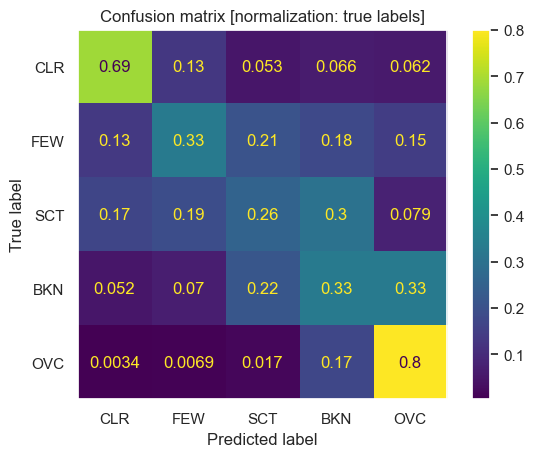

In [30]:
cm_data = display_confusion_matrix(model_trained, visualization_dataloader, ConfusionMatrixNormalization.TRUE_LABELS)

In [31]:
cm_data

,true label,predicted label,index
0,CLR,CLR,1066
1,OVC,OVC,1073
2,CLR,CLR,455
3,SCT,BKN,799
4,SCT,OVC,504
...,...,...,...
1090,CLR,CLR,517
1091,CLR,BKN,1050
1092,OVC,BKN,220
1093,CLR,CLR,124


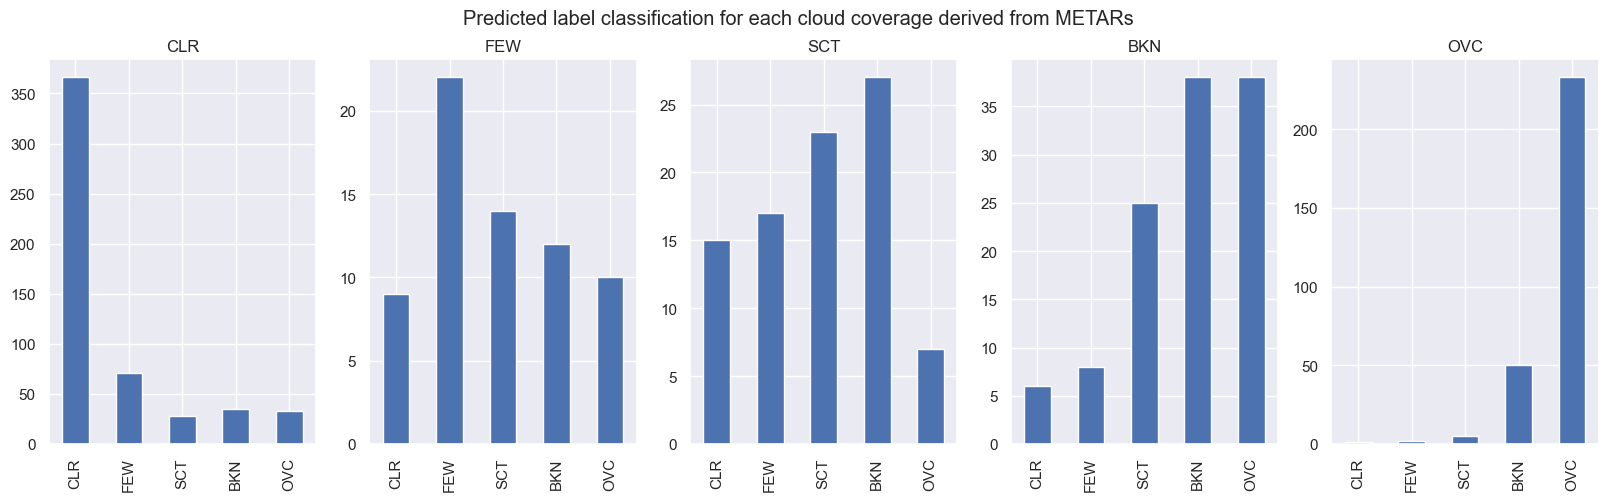

In [32]:
from collections import Counter

cc_counts = {}
fig, axs = plt.subplots(figsize=(4 * len(class_names), 5), ncols=len(class_names))
fig.suptitle('Predicted label classification for each cloud coverage derived from METARs')
for i, cc in enumerate(class_names):
    ax: plt.Axes = axs[i]
    counted_labels = pd.Series(Counter(cm_data[cm_data['true label'] == cc]['predicted label']))
    for cc_ in class_names:
        if cc_ not in counted_labels:
            counted_labels[cc_] = 0
    counted_labels = counted_labels.loc[class_names]
    counted_labels.plot.bar(ax=ax, title=cc)
    cc_counts[cc] = counted_labels

In [33]:
# rows   = label given by METAR
# colums = predicted label
cc_dist = pd.DataFrame(cc_counts).T
cc_dist

,CLR,FEW,SCT,BKN,OVC
CLR,366,71,28,35,33
FEW,9,22,14,12,10
SCT,15,17,23,27,7
BKN,6,8,25,38,38
OVC,1,2,5,50,233


In [34]:
cc_dist_rel = (cc_dist.T / cc_dist.sum(axis=1)).T
assert(all([math.isclose(x, 1.0) for x in cc_dist_rel.sum(axis=1)]))
cc_dist_rel

,CLR,FEW,SCT,BKN,OVC
CLR,0.686679,0.133208,0.052533,0.065666,0.061914
FEW,0.134328,0.328358,0.208955,0.179104,0.149254
SCT,0.168539,0.191011,0.258427,0.303371,0.078652
BKN,0.052174,0.069565,0.217391,0.330435,0.330435
OVC,0.003436,0.006873,0.017182,0.171821,0.800687


In [49]:
def direct_neighbor_accumulation(data_collection:List[pd.DataFrame], labels:List[str]) -> pd.DataFrame:
    result = []
    for i, cc in enumerate(class_names):
        local_result = {'cloud cover': cc}
        for k, data in enumerate(data_collection):
            cc_sum = data.loc[cc, cc]
            if i > 0:
                cc_sum += data.loc[cc, class_names[i - 1]]
            if i < len(class_names) - 1:
                cc_sum += data.loc[cc, class_names[i + 1]]
            local_result[labels[k]] = cc_sum
        result += [local_result]
    result = pd.DataFrame(result)
    result.set_index('cloud cover', inplace=True)
    return result

direct_neighbor_accumulation([cc_dist_rel], ['f1_score'])

,f1_score
cloud cover,
CLR,0.819887
FEW,0.671642
SCT,0.752809
BKN,0.878261
OVC,0.972509


In [36]:
false_predictions = cm_data[cm_data['true label'] != cm_data['predicted label']].copy()
print(f'{false_predictions.shape[0]} of {cm_data.shape[0]} images were not identified correctly'
      f' [{false_predictions.shape[0] / cm_data.shape[0] * 100.0:.2f} %]')

413 of 1095 images were not identified correctly [37.72 %]


In [37]:
false_predictions_grouped = [false_predictions[false_predictions['true label'] == cc] for cc in class_names]
all_predictions_grouped = [cm_data[cm_data['true label'] == cc] for cc in class_names]
for i, cc in enumerate(class_names):
    print(f'{false_predictions_grouped[i].shape[0]} of {all_predictions_grouped[i].shape[0]} {cc} images were not identified correctly'
        f' [{false_predictions_grouped[i].shape[0] / all_predictions_grouped[i].shape[0] * 100.0:.2f} %]')

167 of 533 CLR images were not identified correctly [31.33 %]
45 of 67 FEW images were not identified correctly [67.16 %]
66 of 89 SCT images were not identified correctly [74.16 %]
77 of 115 BKN images were not identified correctly [66.96 %]
58 of 291 OVC images were not identified correctly [19.93 %]


In [38]:
false_predictions['image path'] = false_predictions['index'].apply(lambda x: visualization_dataset.get_image_path(x))
false_predictions['timedelta [minutes]'] = false_predictions['index'].apply(lambda x: visualization_dataset.get_timedelta_minutes(x))
false_predictions

,true label,predicted label,index,image path,timedelta [minutes]
3,SCT,BKN,799,data\dataset\test\NUC\bd63ef5e-0cd2-4c52-baf4-...,20.016267
4,SCT,OVC,504,data\dataset\test\STS\70da06d5-6ca5-4e7d-899a-...,-5.183733
9,BKN,SCT,81,data\dataset\test\VDF\0f869337-4a3c-4e24-92c0-...,-9.183733
10,SCT,FEW,901,data\dataset\test\DLO\d3b5ec2b-78ef-4e2b-b8d1-...,9.516267
16,OVC,BKN,47,data\dataset\test\MLS\08d194aa-752e-4336-a48d-...,-12.150400
...,...,...,...,...,...
1086,OVC,BKN,1035,data\dataset\test\O32\f328fca0-a5ab-4025-ae42-...,7.516267
1089,SCT,BKN,740,data\dataset\test\SMP\ae5339e9-c3ac-4d2e-8aea-...,0.649600
1091,CLR,BKN,1050,data\dataset\test\BLU\f618f679-56a5-4a7c-a0fa-...,-6.150400
1092,OVC,BKN,220,data\dataset\test\VUO\2de349df-5736-496a-8bbf-...,-24.517067


In [39]:
false_predictions_idx = 0

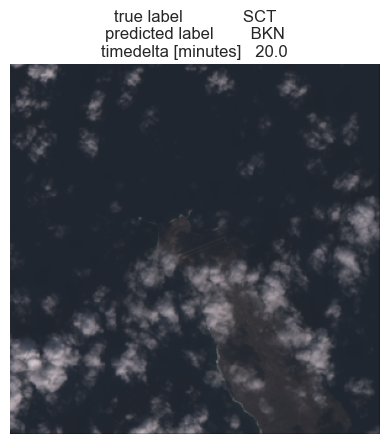

In [40]:
if false_predictions_idx < len(validation_dataset):
    row = false_predictions.iloc[false_predictions_idx]
    image = rasterio.open(row['image path'])
    image_tensor = torch.from_numpy(image.read())
    image.close()

    plt.title(row[['true label', 'predicted label', 'timedelta [minutes]']].to_string(float_format=(lambda x: f'{x:.1f}')))
    plt.axis('off')
    plt.imshow(image_tensor.permute(1, 2, 0))
    false_predictions_idx += 1

In [41]:
pd.set_option('display.max_colwidth', None)

In [42]:
scoreboard = pd.DataFrame(state.scoreboard)
scoreboard['accuracy'] = scoreboard['accuracy'].apply(lambda t: t.item())
scoreboard.head()

,epoch,phase,loss,accuracy,precision,recall,f1_score,time,precision CLR,recall CLR,...,f1_score FEW,precision SCT,recall SCT,f1_score SCT,precision BKN,recall BKN,f1_score BKN,precision OVC,recall OVC,f1_score OVC
0,0,Training,1.420487,0.481477,0.555989,0.481477,0.508175,245.597299,0.738777,0.535740,...,0.174349,0.163793,0.275762,0.205516,0.266413,0.255708,0.260951,0.602827,0.628626,0.615456
1,0,Validation,1.343604,0.575840,0.644463,0.575840,0.585184,23.297181,0.891821,0.605735,...,0.152542,0.202312,0.380435,0.264151,0.280488,0.184000,0.222222,0.559902,0.860902,0.678519
2,1,Training,1.269382,0.568977,0.637970,0.568977,0.589858,88.360101,0.861241,0.609106,...,0.189206,0.235966,0.359942,0.285057,0.301871,0.338813,0.319277,0.647821,0.784593,0.709677
3,1,Validation,1.313405,0.615804,0.659141,0.615804,0.621967,8.652291,0.899522,0.673835,...,0.174603,0.256410,0.217391,0.235294,0.311594,0.344000,0.326996,0.568579,0.857143,0.683658
4,2,Training,1.251044,0.582386,0.650523,0.582386,0.602506,85.324274,0.867310,0.615239,...,0.231055,0.245261,0.300435,0.270059,0.341969,0.361644,0.351531,0.657874,0.806467,0.724631


In [43]:
print(f'Total time: {scoreboard.time.sum() / 60:.1f} [minutes]')

Total time: 71.6 [minutes]


In [44]:
scoreboard_training = scoreboard[scoreboard['phase'] == 'Training']
scoreboard_validation = scoreboard[scoreboard['phase'] == 'Validation']

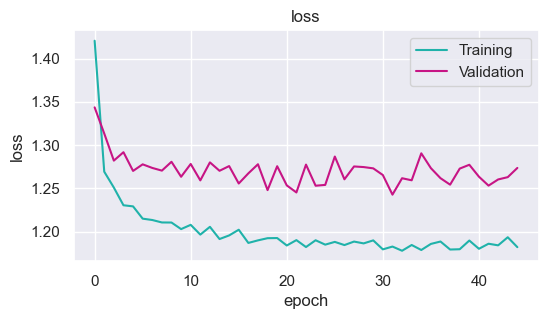

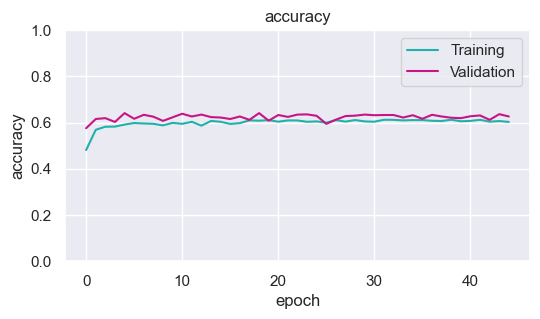

In [45]:
def plot_scoreboard(x_label:str, y_labels:List[str], figsize:Tuple[float, float]):
    def plot_single(ax:plt.Axes, data:pd.DataFrame, y_label:str, phase:str, colors):
        ax.plot(x_label, y_label, data=data, label=phase, color=colors[phase])
        ax.legend(loc='best')
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(y_label)
        if y_label.startswith('f1_score') or y_label.startswith('precision') or y_label.startswith('recall') or y_label.startswith('accuracy'):
            ax.set_ylim(0, 1)

    assert x_label in scoreboard, f'Label {x_label} is not in scoreboard'
    for y_label in y_labels:
        assert y_label in scoreboard, f'Label {y_label} is not in scoreboard'
    colors = {
        'Training': 'lightseagreen',
        'Validation': 'mediumvioletred'
    }
    fig, axs = plt.subplots(figsize=(figsize[0] * len(y_labels), figsize[1]), ncols=len(y_labels))
    for phase in ['Training', 'Validation']:
        data = scoreboard[scoreboard['phase'] == phase]
        if isinstance(axs, plt.Axes):
            plot_single(axs, data, y_labels[0], phase, colors)
        else:
            for i, y_label in enumerate(y_labels):
                plot_single(axs[i], data, y_label, phase, colors)
                

plot_scoreboard('epoch', ['loss'], figsize=(6, 3))
plot_scoreboard('epoch', ['accuracy'], figsize=(6, 3))

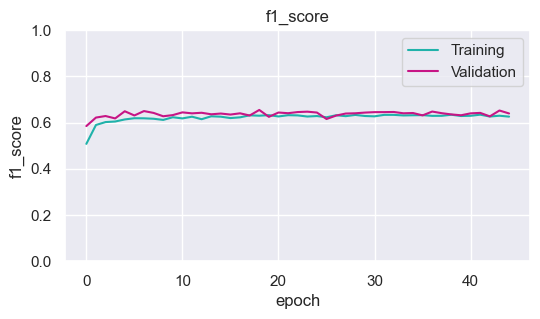

In [46]:
plot_scoreboard('epoch', ['f1_score'], figsize=(6, 3))

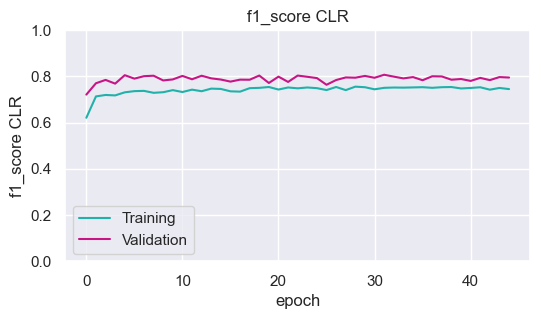

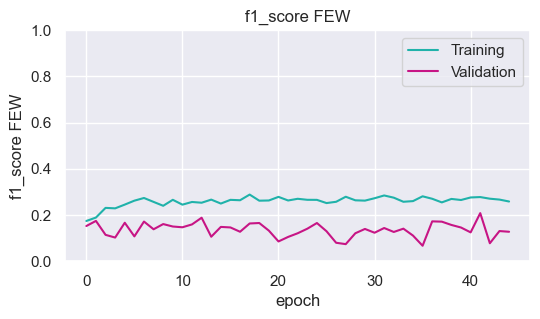

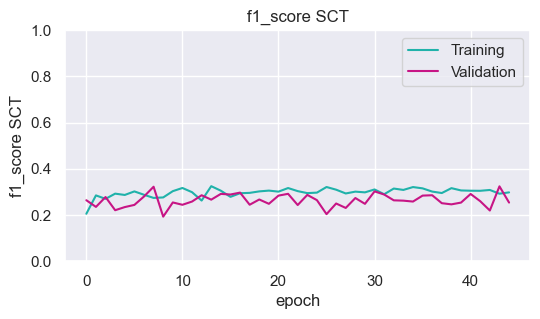

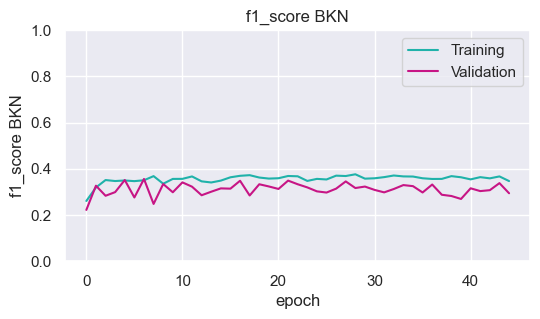

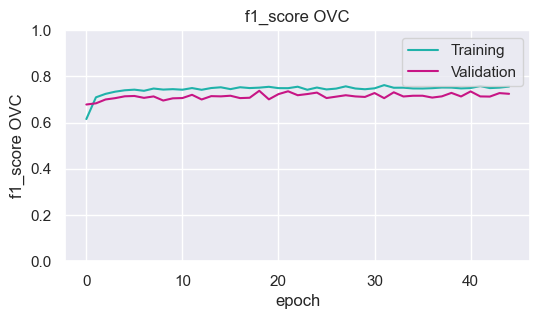

In [47]:
for cc in class_names:
    plot_scoreboard('epoch', [f'f1_score {cc}'], figsize=(6, 3))

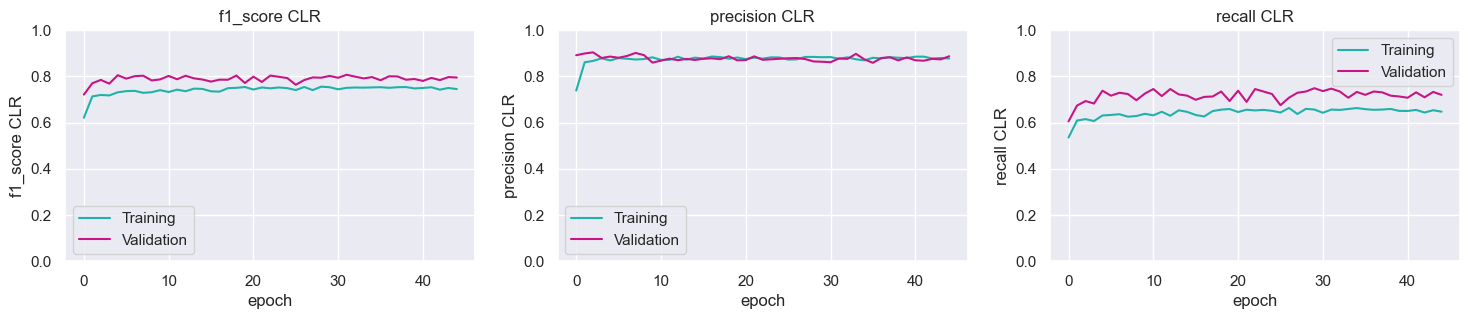

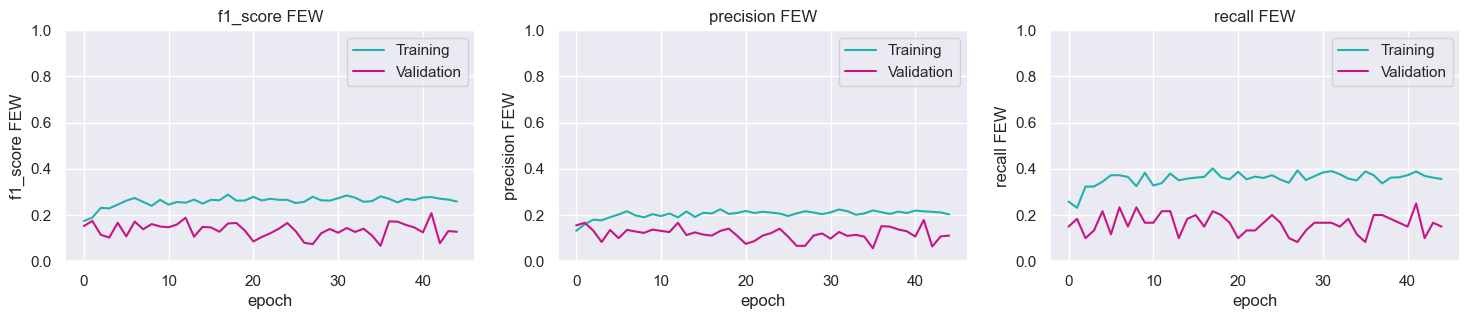

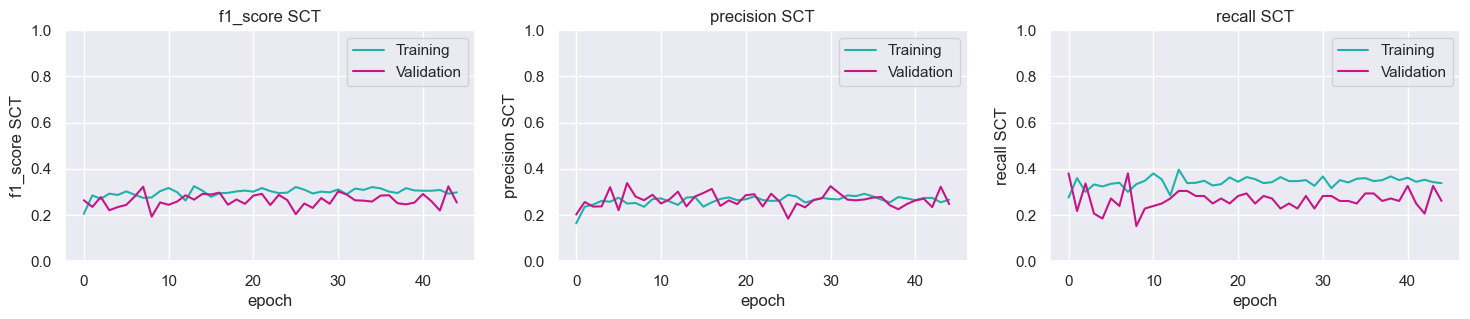

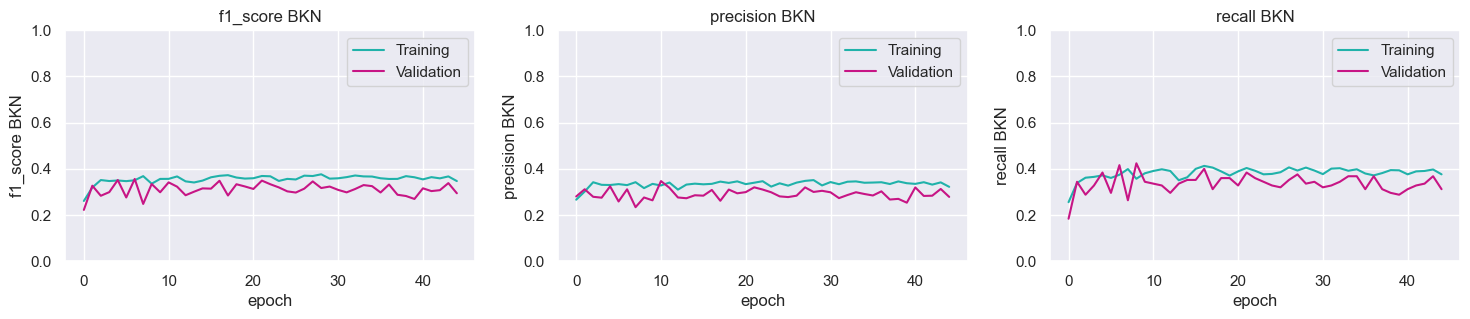

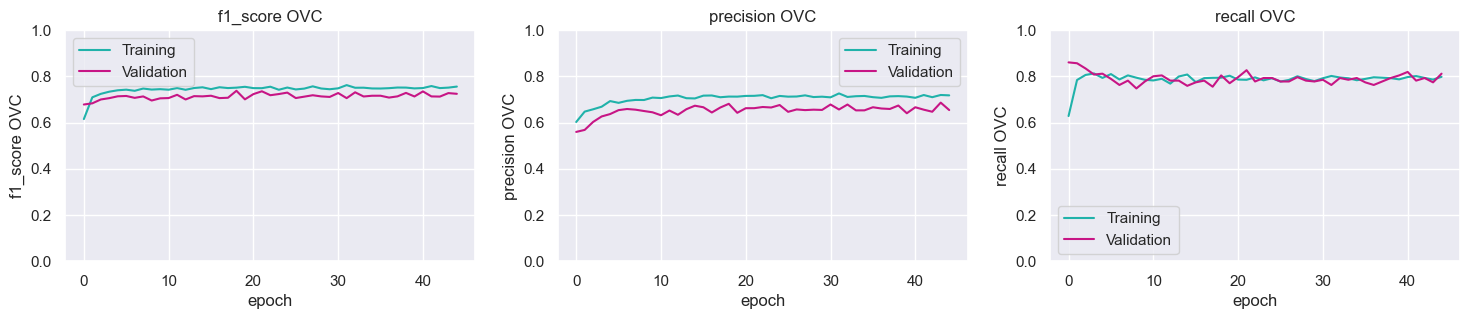

In [48]:
for cc in class_names:
    plot_scoreboard('epoch', [f'f1_score {cc}', f'precision {cc}', f'recall {cc}'], figsize=(6, 3))